# GPyとNumbaを用いたガウス過程計算例

以下のコードはProxima Technology（株）のsmart MPCを参考にしております

In [1]:
import GPy
from numba import njit, prange
import numpy as np
from typing import Tuple, List
from functools import partial
import logging
import os

In [2]:
"""npzファイルからデータを取得する部分までを親クラスとして作成する"""

class get_data_from_npz:
    """npzからデータを得るクラス"""

    X_input_list: List[np.ndarray]
    """学習での入力データ"""

    Y_output_list: List[np.ndarray]
    """学習での出力データ"""

    def __init__(self):
        self.X_input_list = []  # 学習用データ
        self.Y_output_list = []  # 学習用データ
        #self.X_val_list = []  # 推論用データ
        #self.Y_val_list = []  # 推論用データ
        self.X_input_array = None # np.ndarrayのデータ
        self.Y_output_array = None # np.ndarray
    
    
    def clear_data(self):
        """データを空にする関数"""
        self.X_input_list.clear()
        self.Y_output_list.clear()
        #self.X_val_list.clear()
        #self.Y_val_list.clear()


    def get_data_from_npz(
            self,
            file_path: str,  #データが入ったファイルのパス
    ) -> None:
        """
        データは系列に沿って縦に並んでいるものとする
        """
        data = np.load(file_path)
        variables = data.files
        logging.info("get file %s", file_path)
        logging.info("get %s as data", variables)

        """npzファイルの一番最初の変数を入力として扱う"""
        input_var = variables[0]
        self.X_input_list.append(data[input_var])
        logging.info("get %s as input",input_var)

        """それ以外を出力として処理する"""
        out_list = []  # 出力を入れる配列
        for var in variables[1:]:
            out_list.append(data[var])
            logging.info("get %s as output",var)
        if len(out_list) == 1:
            out_array = np.hstack(out_list)
        self.Y_output_list.append(out_array)
    

    def get_data_from_folder(
            self,
            folder_path: str,
    ) -> None:
        """フォルダーからまとめてデータを採取する関数"""

        """まずはnpzファイルの一覧を作る"""
        npz_files = [
            f for f in os.listdir(folder_path) 
            if os.path.isfile(os.path.join(folder_path, f)) and f.endswith(".npz")
        ]
        logging.info("get files %s", npz_files)

        """ファイルごとにデータを読み込ませる"""
        for f in npz_files:
            path = folder_path + "/" + f
            self.get_data_from_npz(
                file_path=path
            )


    def make_array_data(self) -> None:
        """X_input_list及びY_output_listからnp.ndarrayに型を変更する"""
        """vstackで配列内の要素を縦に繋げる"""
        self.X_input_array = np.vstack(self.X_input_list)
        self.Y_output_array = np.vstack(self.Y_output_list)

In [3]:
"""get_data_from_npzの子クラスとしてガウス学習クラスを作成する"""

class train_GP_model(get_data_from_npz):
    """ガウス過程モデルをGPyで学習し、パラメータを取り出して保存するクラス"""
    def __init__(self):
        super().__init__()

    def get_trained_GP(
            self,
            output_idx: int,  # 出力のインデックス（出力のうちこれを学習する）
            save_name: str,
    ) -> None:
        """GPyを使って最適なパラメータを計算する関数"""
        """こっちはスパースではない普通のガウス過程用（後で完成させる）"""
        X_input = self.X_input_array
        Y_output = self.Y_output_array

        """入出力データの平均と標準偏差を取る"""
        X_mean = np.mean(X_input, axis=0)  # 平均 (列ごと)
        X_std = np.std(X_input, axis=0)    # 標準偏差 (列ごと)
        Y_mean = np.mean(Y_output, axis=0)
        Y_std = np.std(Y_output, axis=0)

        """必要であればデータを標準化する"""
        #X_input = (X_input-X_mean)/X_std
        #Y_output = (Y_output-Y_mean)/Y_std

        """カーネルを選ぶ"""
        """chatGPTによるとlengthscaleの初期値に出力データの標準偏差を,varianceの初期値に入力データの分散を使うと上手く収束しやすいらしい"""
        kernel = GPy.kern.RBF(input_dim=X_input.shape[1], ARD=True, lengthscale=Y_std[output_idx], variance=X_std)

        """ガウス過程回帰クラスを定義"""
        m = GPy.models.GPRegression(
            X_input, Y_output[:,[output_idx]], kernel
        )

        """最適化"""
        m.optimize(messages=True)

        """パラメータの抜き出しと計算"""
        theta_1 = kernel.variance[0]
        theta_2 = 1/np.array(np.array(kernel.lengthscale)**2)

        K = kernel.K(X_input, X_input) + m.Gaussian_noise.variance * np.eye(X_input.shape[0])

        try:
            K_inv = np.linalg.inv(K)
        except:
            K_inv = np.linalg.pinv(K)

        """ここでは推論は行わず,推論に必要な変数値をnpzファイルに保存しておく"""
        np.savez(
            save_name,
            theta_1=theta_1,
            theta_2=theta_2,
            X = X_input,
            Y = Y_output,
            K_inv = K_inv,
            input_mean = X_mean,
            input_std = X_std,
            output_mean = Y_mean,
            output_std = Y_std,
        )


    def get_trained_sparse_GP(
            self,
            output_idx: int,  # 出力のインデックス（出力のうちこれを学習する）
            save_name: str,
            inducting_num: int,  # スパースガウス過程なので誘導点の個数を指定する
    ) -> None:
        """GPyを使って最適なパラメータを計算する関数"""
        """こっちはスパースガウス過程（FITC用）"""
        X_input = self.X_input_array
        Y_output = self.Y_output_array

        """データの平均と標準偏差を取る"""
        X_mean = np.mean(X_input, axis=0)  # 平均 (列ごと)
        X_std = np.std(X_input, axis=0)    # 標準偏差 (列ごと)
        Y_mean = np.mean(Y_output, axis=0)
        Y_std = np.std(Y_output, axis=0)

        """必要であればデータを標準化する"""
        #X_input = (X_input-X_mean)/X_std
        #Y_output = (Y_output-Y_mean)/Y_std

        """誘導点を選ぶ"""
        inducing_idx = np.random.choice(X_input.shape[0], inducting_num, replace=False)

        """カーネルを選ぶ"""
        kernel = GPy.kern.RBF(input_dim=X_input.shape[1], ARD=True, lengthscale=Y_std[output_idx], variance=X_std)

        """スパースガウス過程クラスを定義"""
        m = GPy.models.SparseGPRegression(
            X_input, Y_output[:,[output_idx]], kernel, Z=X_input[inducing_idx]
        )

        """最適化"""
        m.optimize(messages=True)

        """パラメータの抜き出しと計算"""
        theta_1 = kernel.variance[0]
        theta_2 = 1/np.array(np.array(kernel.lengthscale)**2)
        Z_post = np.array(m.inducing_inputs)

        K_MM = kernel.K(Z_post, Z_post)
        K_MN = kernel.K(Z_post, X_input)
        """エラー吐いたら疑似逆行列で計算する様に変える"""
        try:
            K_MM_inv = np.linalg.inv(K_MM)
        except:
            K_MM_inv = np.linalg.pinv(K_MM)
        Lam_with_noise_inv = np.zeros(K_MN.shape[1])
        for n in range(K_MN.shape[1]):
            Lam_with_noise_inv[n] = 1 / (
                kernel.variance
                - np.dot(K_MM_inv @ K_MN[:, n], K_MN[:, n])
                + m.Gaussian_noise.variance
            )
        Q_MM = K_MM + K_MN @ np.diag(Lam_with_noise_inv) @ K_MN.T
        """エラー吐いたら疑似逆行列で計算する様に変える"""
        try:
            Q_MM_inv = np.linalg.inv(Q_MM)
        except:
            Q_MM_inv = np.linalg.pinv(Q_MM)
        #U = K_MM @ Q_MM_inv @ K_MN @ (np.diag(Lam_with_noise_inv) @ Y_output[:, output_idx])
        #K_MM_invUT = (K_MM_inv @ U).T
        K_MM_invUT = (Q_MM_inv @ K_MN @ (np.diag(Lam_with_noise_inv) @ Y_output[:, output_idx])).T  # KMMを始めから掛けない

        """ここでは推論は行わず,推論に必要な変数値をnpzファイルに保存しておく"""
        np.savez(
            save_name,
            theta_1=theta_1,
            theta_2=theta_2,
            Z=Z_post,
            mean_mtr=K_MM_invUT,
            cov_mtr=K_MM_inv - Q_MM_inv,
            input_mean = X_mean,
            input_std = X_std,
            output_mean = Y_mean,
            output_std = Y_std,
        )

In [4]:
"""上のクラスで計算したパラメータを使って計算を実行する為のクラス及び関数"""

@njit(cache=True,fastmath=True)
def get_pred(
    x_input: np.ndarray,
    theta_1: np.ndarray,
    theta_2: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
    K_inv: np.ndarray,
    input_mean: np.ndarray,
    input_std: np.ndarray,
    output_mean: np.ndarray,
    output_std: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    X_norm = (X-x_input)*theta_2
    k_ast = theta_1 * np.exp(-0.5*((X-x_input)*X_norm).sum(axis=1))
    mean = np.dot(k_ast,K_inv@Y)
    deviation = np.sqrt(theta_1 - np.dot(k_ast,K_inv@k_ast))
    return mean, deviation


@njit(cache=True,fastmath=True,parallel=True)
def get_preds_series(
    x_inputs: np.ndarray,
    theta_1: np.ndarray,
    theta_2: np.ndarray,
    X: np.ndarray,
    Y: np.ndarray,
    K_inv: np.ndarray,
    input_mean: np.ndarray,
    input_std: np.ndarray,
    output_mean: np.ndarray,
    output_std: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """複数の入力分の予測をまとめて行う関数"""
    """入力が一次元だったら二次元に直す"""
    if x_inputs.ndim == 1:
        x_inputs.reshape(-1,1)
    N = x_inputs.shape[0]
    #nx = x_inputs.shape[1]
    preds = np.zeros((N,1),dtype=np.float64)
    deviations = np.zeros((N,1),dtype=np.float64)
    for i in prange(N):
        pred, deviation = get_pred(
            x_input=x_inputs[i],
            theta_1=theta_1,
            theta_2=theta_2,
            X=X,
            Y=Y,
            K_inv=K_inv,
            input_mean=input_mean,
            input_std=input_std,
            output_mean=output_mean,
            output_std=output_std,
        )
        preds[i] += pred
        deviations[i] += deviation
    return preds, deviations


@njit(cache=True,fastmath=True)
def get_sparse_pred(
    x_input: np.ndarray,
    theta_1: np.ndarray,
    theta_2: np.ndarray,
    Z: np.ndarray,
    mean_mtr: np.ndarray,
    cov_mtr: np.ndarray,
    input_mean: np.ndarray,
    input_std: np.ndarray,
    output_mean: np.ndarray,
    output_std: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """予測，標準偏差とその微分を返す"""
    """まずは（必要であれば）入力の標準化"""
    #x_input = (x_input-input_mean)/input_std
    Z_norm = (Z-x_input)*theta_2
    k_ast = theta_1 * np.exp(-0.5*((Z-x_input)*Z_norm).sum(axis=1))  # カーネルはRBFカーネルを使用
    k_ = cov_mtr @ k_ast
    Z_k = Z_norm.T * k_ast
    mean = np.dot(mean_mtr, k_ast)
    deviation = np.sqrt(theta_1 - np.dot(k_ast, k_))
    #mean = mean*output_std + output_mean
    #deviation = deviation*output_std
    return mean, deviation, Z_k@mean_mtr, -Z_k@k_/deviation


@njit(cache=True,fastmath=True,parallel=True)
def get_sparse_preds_series(
    x_inputs: np.ndarray,
    theta_1: np.ndarray,
    theta_2: np.ndarray,
    Z: np.ndarray,
    mean_mtr: np.ndarray,
    cov_mtr: np.ndarray,
    input_mean: np.ndarray,
    input_std: np.ndarray,
    output_mean: np.ndarray,
    output_std: np.ndarray,
) -> Tuple[np.ndarray, np.ndarray]:
    """複数の入力分の予測をまとめて行う関数"""
    """入力が一次元だったら二次元に直す"""
    if x_inputs.ndim == 1:
        x_inputs.reshape(-1,1)
    N = x_inputs.shape[0]
    #nx = x_inputs.shape[1]
    preds = np.zeros((N,1),dtype=np.float64)
    deviations = np.zeros((N,1),dtype=np.float64)
    for i in prange(N):
        pred, deviation, _, _ = get_sparse_pred(
            x_input=x_inputs[i],
            theta_1=theta_1,
            theta_2=theta_2,
            Z=Z,
            mean_mtr=mean_mtr,
            cov_mtr=cov_mtr,
            input_mean=input_mean,
            input_std=input_std,
            output_mean=output_mean,
            output_std=output_std,
        )
        preds[i] += pred
        deviations[i] += deviation
    return preds, deviations


class transform_GP_to_numba:
    """ガウス過程の計算を取りまとめるクラス"""

    def __init__(
            self,
            dir_name: str,  # ガウス過程に必要な変数値が入っているフォルダ
            file_name: str,  # 変数値が入っているファイル名
    ) -> None:
        """ファイルから必要な情報を読み込む"""
        GP_info = np.load(dir_name+file_name)
        theta_1 = GP_info["theta_1"]
        theta_2 = GP_info["theta_2"]
        X = GP_info["X"]
        Y = GP_info["Y"]
        K_inv = GP_info["K_inv"]
        input_mean = GP_info["input_mean"]
        input_std = GP_info["input_std"]
        output_mean = GP_info["output_mean"]
        output_std = GP_info["output_std"]
        """関数を作ってしまう"""
        self.get_pred = partial(
            get_pred,
            theta_1=theta_1,
            theta_2=theta_2,
            X=X,
            Y=Y,
            K_inv=K_inv,
            input_mean=input_mean,
            input_std=input_std,
            output_mean=output_mean,
            output_std=output_std,
        )
        self.get_preds_series = partial(
            get_preds_series,
            theta_1=theta_1,
            theta_2=theta_2,
            X=X,
            Y=Y,
            K_inv=K_inv,
            input_mean=input_mean,
            input_std=input_std,
            output_mean=output_mean,
            output_std=output_std,
        )


class transform_GP_to_numba_sparse:
    """ガウス過程の計算を取りまとめるクラス"""

    def __init__(
            self,
            dir_name: str,  # ガウス過程に必要な変数値が入っているフォルダ
            file_name: str,  # 変数値が入っているファイル名
    ) -> None:
        """ファイルから必要な情報を読み込む"""
        GP_info = np.load(dir_name+file_name)
        theta_1 = GP_info["theta_1"]
        theta_2 = GP_info["theta_2"]
        Z = GP_info["Z"]
        mean_mtr = GP_info["mean_mtr"]
        cov_mtr = GP_info["cov_mtr"]
        input_mean = GP_info["input_mean"]
        input_std = GP_info["input_std"]
        output_mean = GP_info["output_mean"]
        output_std = GP_info["output_std"]
        """関数を作ってしまう"""
        self.get_sparse_pred = partial(
            get_sparse_pred,
            theta_1=theta_1,
            theta_2=theta_2,
            Z=Z,
            mean_mtr=mean_mtr,
            cov_mtr=cov_mtr,
            input_mean=input_mean,
            input_std=input_std,
            output_mean=output_mean,
            output_std=output_std,
        )
        self.get_sparse_preds_series = partial(
            get_sparse_preds_series,
            theta_1=theta_1,
            theta_2=theta_2,
            Z=Z,
            mean_mtr=mean_mtr,
            cov_mtr=cov_mtr,
            input_mean=input_mean,
            input_std=input_std,
            output_mean=output_mean,
            output_std=output_std,
        )

In [5]:
"""テストデータを作ってみる"""

import sys
import logging
logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

test_input1 = np.linspace(0,10,13)
test_output1 = np.array([x*(1+np.sin(x)) for x in test_input1])
noise1 = np.random.normal(loc=0.0, scale=0.5, size=test_output1.shape)
test_output1 += noise1
test_input2 = np.linspace(0,10,7)
test_output2 = np.array([x*(1+np.sin(x)) for x in test_input2])
noise2 = np.random.normal(loc=0.0, scale=0.5, size=test_output2.shape)
test_output2 += noise2

np.savez(
    "./test_train_data/test_data1",
    test_input = test_input1.reshape(-1,1),
    test_output = test_output1.reshape(-1,1),
)
np.savez(
    "./test_train_data/test_data2",
    test_input = test_input2.reshape(-1,1),
    test_output = test_output2.reshape(-1,1),
)

In [6]:
data1 = np.load("./test_train_data/test_data1.npz")
data1.files
data1["test_output"]

array([[-0.02160732],
       [ 1.88587693],
       [ 2.68471285],
       [ 4.20112444],
       [ 1.92830701],
       [ 0.32484371],
       [ 0.79052839],
       [ 3.83570227],
       [ 9.3722235 ],
       [14.54963106],
       [15.26402155],
       [11.87278132],
       [ 5.17029175]])

In [7]:
GP_trainer = train_GP_model()
GP_trainer.get_data_from_folder(folder_path="./test_train_data")
#print(GP_trainer.X_input_list)
GP_trainer.make_array_data()

21:04:15 [INFO] get files ['test_data2.npz', 'test_data1.npz']
21:04:15 [INFO] get file ./test_train_data/test_data2.npz
21:04:15 [INFO] get ['test_input', 'test_output'] as data
21:04:15 [INFO] get test_input as input
21:04:15 [INFO] get test_output as output
21:04:15 [INFO] get file ./test_train_data/test_data1.npz
21:04:15 [INFO] get ['test_input', 'test_output'] as data
21:04:15 [INFO] get test_input as input
21:04:15 [INFO] get test_output as output


In [8]:
GP_trainer.get_trained_GP(
    output_idx=0,
    save_name="./test_result_data/GPn_test"
)

"""
GP_trainer.get_trained_sparse_GP(
    output_idx=0,
    save_name="./test_result_data/GP_test",
    inducting_num=5,
)
"""

21:04:15 [INFO] initializing Y
21:04:15 [INFO] initializing inference method
21:04:15 [INFO] adding kernel and likelihood as parameters


'\nGP_trainer.get_trained_sparse_GP(\n    output_idx=0,\n    save_name="./test_result_data/GP_test",\n    inducting_num=5,\n)\n'

In [9]:
GP_predict = transform_GP_to_numba(
    dir_name="./test_result_data",
    file_name="/GPn_test.npz",
)

eval_input = np.linspace(0,10,50)
eval_output, eval_deviations = GP_predict.get_preds_series(x_inputs=eval_input)

In [10]:
seikai_input = np.linspace(0,10,20)
seikai_output = seikai_input * (1 + np.sin(seikai_input))

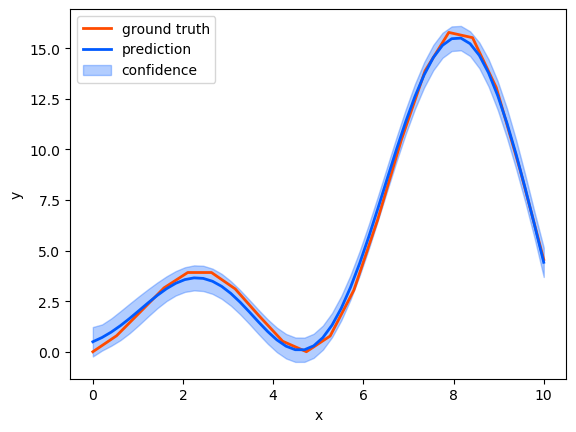

In [11]:
import matplotlib.pyplot as plt

# plot the result
plt.plot(seikai_input,seikai_output, color="#FF4B00", linewidth=2, zorder=1, label="ground truth") # orange line
plt.plot(eval_input, eval_output[:,0], color="#005AFF", linewidth=2, zorder=2, label="prediction") # blue line
plt.fill_between(eval_input, (eval_output - 2.0*eval_deviations)[:,0], (eval_output + 2.0*eval_deviations)[:,0], color="#005AFF", alpha=0.3, zorder=0, label="confidence") # blue area
#plt.scatter(seikai_input, seikai_output, fc="white", ec="#005AFF", linewidth=2, zorder=3, label="training data") # blue points
plt.xlabel("x") # x-axis label
plt.ylabel("y") # y-axis label
plt.legend()
plt.show()

In [12]:
print(eval_output)
print(eval_deviations)

[[ 0.49393374]
 [ 0.70418694]
 [ 0.97143452]
 [ 1.28922272]
 [ 1.64651365]
 [ 2.02793013]
 [ 2.41439722]
 [ 2.78417194]
 [ 3.11421628]
 [ 3.38183154]
 [ 3.56644126]
 [ 3.6513862 ]
 [ 3.62558309]
 [ 3.48490018]
 [ 3.23311764]
 [ 2.88236871]
 [ 2.45299635]
 [ 1.97280588]
 [ 1.47574264]
 [ 1.00007109]
 [ 0.58617227]
 [ 0.27410789]
 [ 0.10111744]
 [ 0.09921948]
 [ 0.2930784 ]
 [ 0.69827669]
 [ 1.32010015]
 [ 2.15290584]
 [ 3.1801007 ]
 [ 4.37471859]
 [ 5.70054664]
 [ 7.11372172]
 [ 8.56469557]
 [10.00045311]
 [11.36686335]
 [12.61104402]
 [13.68362876]
 [14.54083833]
 [15.1462719 ]
 [15.47235185]
 [15.50137214]
 [15.22611846]
 [14.65004504]
 [13.78701039]
 [12.66059058]
 [11.30300507]
 [ 9.75370574]
 [ 8.05769407]
 [ 6.26364367]
 [ 4.42191541]]
[[0.3637031 ]
 [0.32270115]
 [0.33775472]
 [0.35856261]
 [0.3649727 ]
 [0.35578318]
 [0.33737897]
 [0.31827661]
 [0.30547274]
 [0.30160007]
 [0.30445074]
 [0.3094234 ]
 [0.31255143]
 [0.3120585 ]
 [0.30841988]
 [0.30357985]
 [0.29978069]
 [0.2984133